In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**I-Statisticals methods**

In [ ]:
!pip install pmdarima
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.7 MB/s eta 0:00:00


In [ ]:
def first_prep(data_path):
  data=pd.read_csv(data_path)
  data["Time(year-month-day h:m:s)"] = pd.to_datetime(data["Time(year-month-day h:m:s)"])
  data= data.sort_values(by='Time(year-month-day h:m:s)', ascending=True)
  data.set_index('Time(year-month-day h:m:s)', inplace=True)
  data=data.resample('H').mean()
  return data

In [ ]:
solar_data=first_prep('/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/Solar-station-site-1-_Nominal-capacity-50MW_.csv')
wind_data=first_prep('/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/Wind-farm-site-1-_Nominal-capacity-99MW_-_1_.csv')

**Approche univariée**

In [ ]:
'''
Les hypothèses pour le test de Dickey-Fuller

Les hypothèses pour le test de Dickey-Fuller Augmenté (ADF) sont 2 :
Hypothèse nulle (H0) : La série temporelle n'est pas stationnaire car il existe une racine unitaire (si p-value > 0,05)
Hypothèse alternative (H1) : La série temporelle est stationnaire car il n'y a pas de racine unitaire (si p-value ≤ 0,05)

'''

In [ ]:
def check_stationnary(data):
 for column in data.columns:
  dftest=adfuller(data[column],autolag='AIC')
  print('\n',column)
  print("1. ADF:",dftest[0])
  print("2. P-value:",dftest[1])
  #print("3. Num of lags :",dftest[2])
  #print("4. Num of observations used for ADF Regression and critical Values Calculation:",dftest[3])
  if dftest[1]<0.05:
    print(column,'est stationnaire')
  else:
    print(column,"n'est pas stationnaire")

In [ ]:
#Check stationnary for solar_data
check_stationnary(solar_data[['Power (MW)']])


 Power (MW)
1. ADF: -13.155290075912639
2. P-value: 1.3411522286875355e-24
Power (MW) est stationnaire


In [ ]:
#Check stationnary for wind_data
check_stationnary(wind_data[['Power (MW)']])


 Power (MW)
1. ADF: -14.070941361674976
2. P-value: 2.941151986260874e-26
Power (MW) est stationnaire


In [ ]:
'''
les modèles AR (AutoRegressive), ARIMA (AutoRegressive Integrated Moving Average)
et SARIMA (Seasonal ARIMA) sont tous des modèles de prévision univariée.
'''

In [ ]:
'''
Les modèles AR/ARIMA sont généralement utilisés pour la prévision d'une seule étape,
c'est-à-dire la prédiction de la prochaine valeur de la série temporelle en fonction de ses valeurs passées.
Ils ne sont pas directement adaptés à la prévision de plusieurs étapes à l'avance.
'''

In [ ]:
Solar_Power=solar_data[['Power (MW)']].copy()
Wind_Power=wind_data[['Power (MW)']].copy()

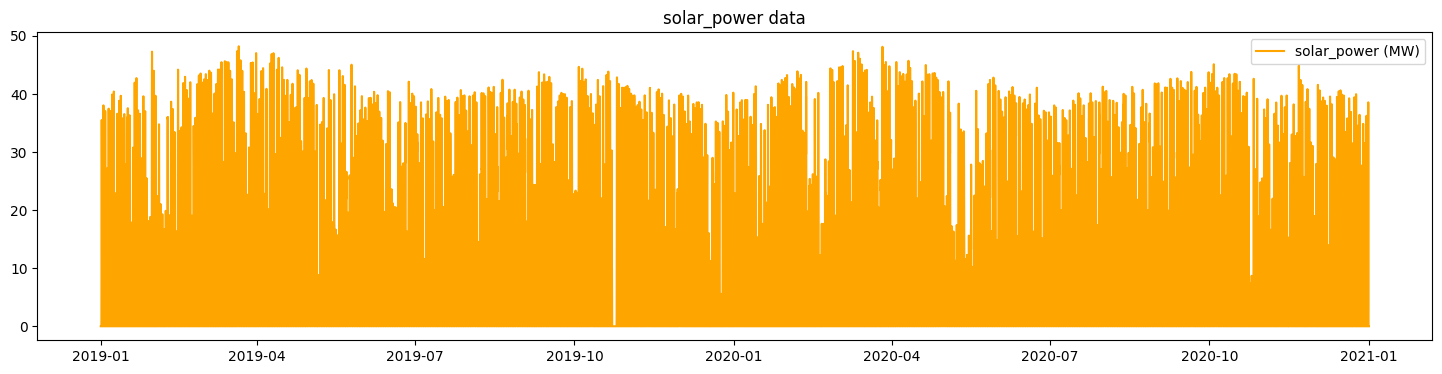

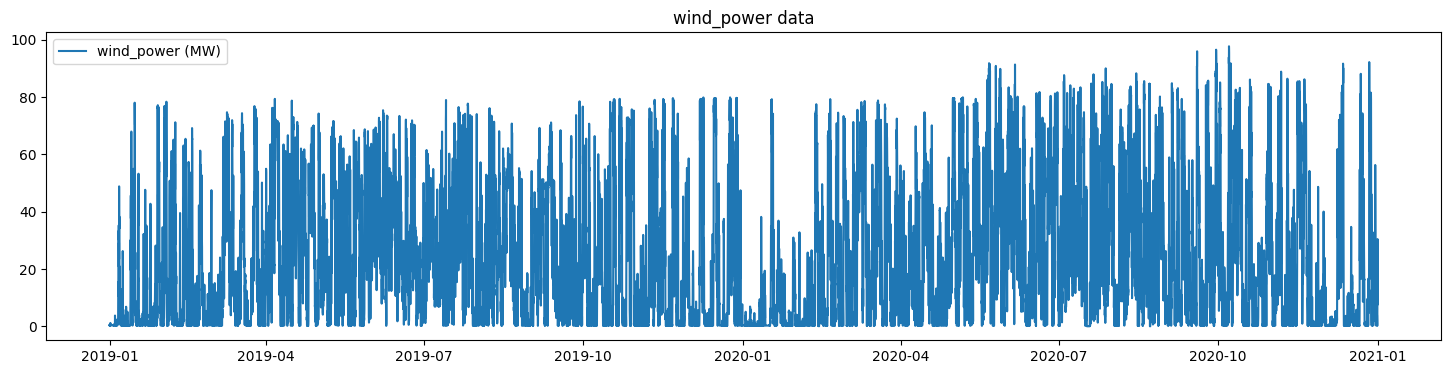

In [ ]:
plt.figure(figsize=(18,4))
plt.title('solar_power data')
plt.plot(Solar_Power,color='orange',label='solar_power (MW)')
plt.legend()
plt.figure(figsize=(18,4))
plt.title('wind_power data')
plt.plot(Wind_Power,label='wind_power (MW)')
plt.legend()

In [ ]:
#Split the data into train and test for solar data
train_S=Solar_Power[:int(len(Solar_Power)*0.8)]
test_S=Solar_Power[int(len(Solar_Power)*0.8):]
#Split the data into train and test
train_W=Wind_Power[:int(len(Wind_Power)*0.8)]
test_W=Wind_Power[int(len(Wind_Power)*0.8):]

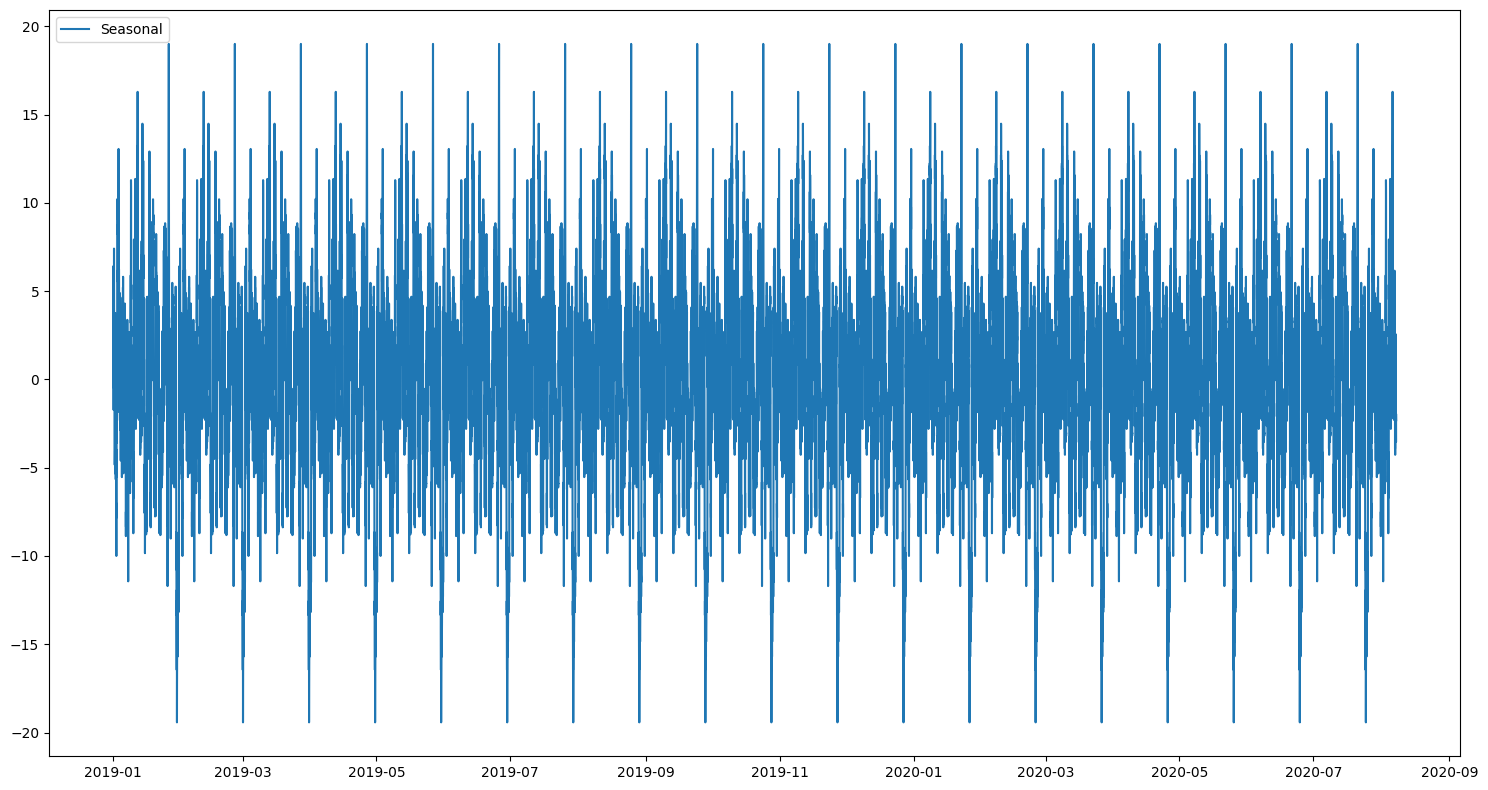

In [ ]:
# Perform STL decomposition
result = seasonal_decompose(train_W, period=2890)  # Change the period according to your data
# Plot the original, seasonal, trend, and residual components
plt.figure(figsize=(15, 8))
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
print(train_S.shape,test_S.shape)
print(train_W.shape,test_W.shape)

(14035, 1) (3509, 1)
(14035, 1) (3509, 1)


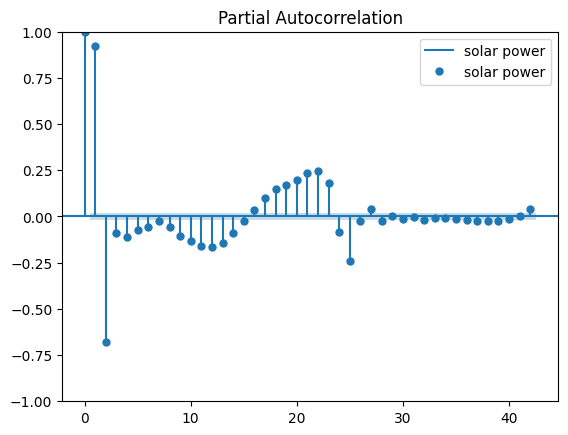

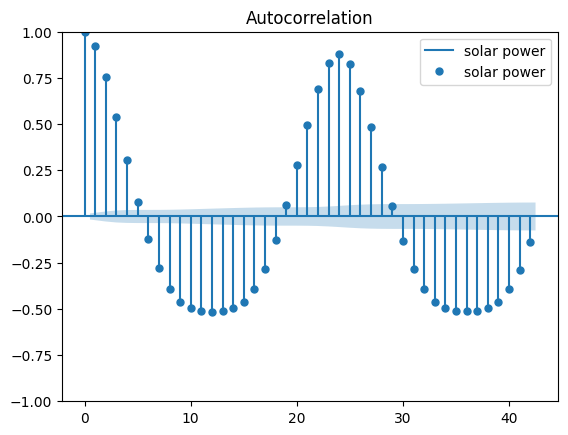

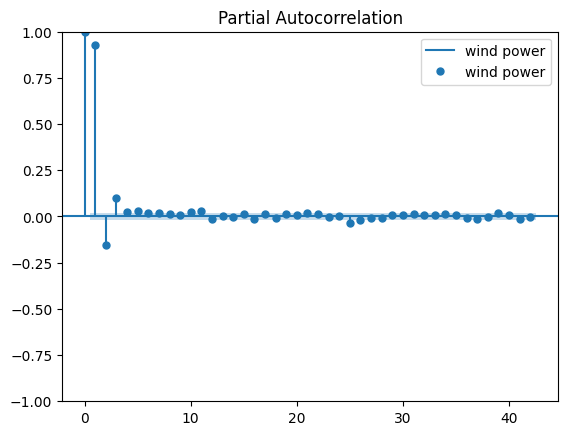

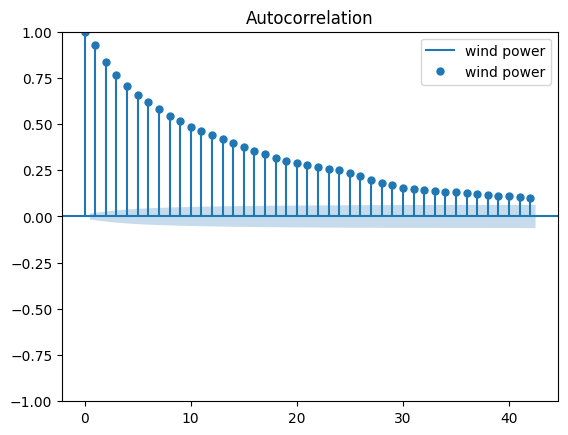

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
pacf_s=plot_pacf(train_S,label='solar power')
plt.legend()
acf_s=plot_acf(train_S,label='solar power')
plt.legend()
pacf_w=plot_pacf(train_W,label='wind power')
plt.legend()
acf_w=plot_acf(train_W,label='wind power')
plt.legend()

**I-1_AR**
    


   

In [ ]:
def evalute_model(model,data,train,test,start,step_in,n_forecast,color_d):
 predictions=model.predict(start=len(train)+step_in+start,end=start+len(train)+step_in+n_forecast,dynamic=False)

 plt.figure(figsize=(10,5))
 plt.plot(data.index[len(train)+start:len(train)+step_in+1+start],data[len(train)+start:len(train)+step_in+1+start],color=color_d)
 plt.plot(data.index[len(train)+step_in+start:len(train)+step_in+n_forecast+1+start],test[step_in+start:step_in+n_forecast+1+start],label='Valeurs Réels',color='green')
 plt.plot(data.index[len(train)+step_in+start:len(train)+step_in+n_forecast+1+start],predictions,linestyle='dashed',color='red',label='Prévision par AR')
 plt.xlabel('Temps')
 plt.ylabel('Energie en (MW)')
 plt.legend()
 plt.title('Valeurs prévisionnelles vs Valeurs réelles')
 mae=mean_absolute_error(test[:n_forecast+1],predictions)
 mse=mean_squared_error(test[:n_forecast+1],predictions)
 rmse = np.sqrt(mse)
 mape = mean_absolute_percentage_error(test[:n_forecast+1],predictions)
 print('mae=',mae)
 print('mse=',mse)
 print('rmse=',rmse)
 print('mape=',mape)
 return predictions

In [ ]:
#build the Model_AR for solar power

model_AR_S=AutoReg(train_S,lags=96).fit()

''''
best order p=110
mae= 0.6250891564305662
mse= 2.1845850999812217
rmse= 1.4780342012217518
mape= 497620301416388.75

'''


"' \nbest order p=110\nmae= 0.6250891564305662\nmse= 2.1845850999812217\nrmse= 1.4780342012217518\nmape= 497620301416388.75\n"

In [ ]:
import pickle
def load_model(file_name):
  with open(file_name, 'rb') as file:
    loaded_model = pickle.load(file)
  return loaded_model

In [ ]:
model_AR_S=load_model('/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/model_AR_S.pkl')
model_AR_W=load_model('/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/model_AR_W.pkl')

mae= 13.113124484841698
mse= 339.7600821505351
rmse= 18.43258208039598
mape= 2.323111065476693e+16


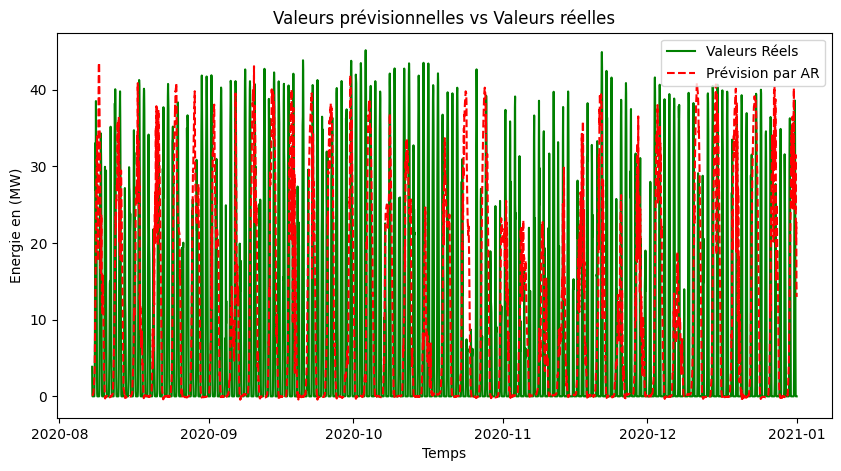

In [ ]:
#Make AR model predictions for solar power
predictions_s=evalute_model(model_AR_S,Solar_Power,train_S,test_S,0,0,len(test_S)-1,'orange')

In [ ]:
#build the Model_AR for wind power
model_AR_W=AutoReg(train_W,lags=2000).fit()

'''
best ordre p=960

mae= 23.84852805711047
mse= 633.0960961986138
rmse= 25.16140091884023
mape= 35.162000214699155

'''

'\nbest ordre p=960\n\nmae= 23.84852805711047\nmse= 633.0960961986138\nrmse= 25.16140091884023\nmape= 35.162000214699155\n\n'

mae= 26.673626492704816
mse= 1091.8478316952576
rmse= 33.04312079231103
mape= 76262449950194.58


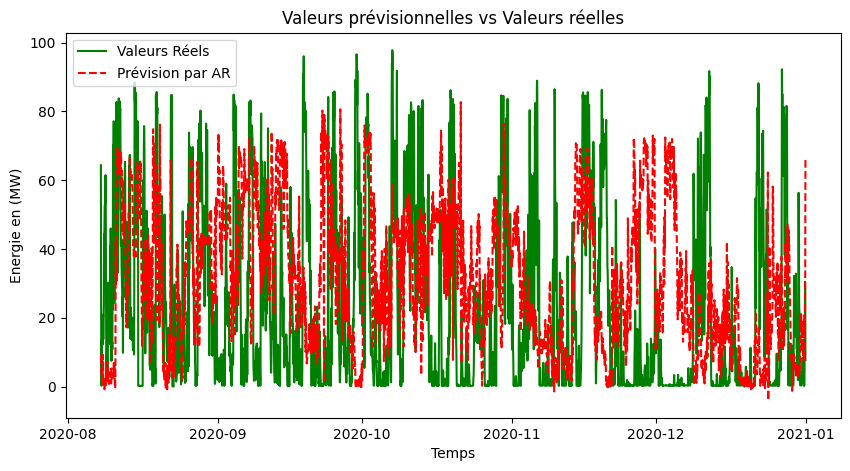

In [ ]:
#Make AR model predictions for wind power
predictions_w=evalute_model(model_AR_W,Wind_Power,train_W,test_W,0,0,len(test_W)-1,None)

In [ ]:
import pickle
def save_model(model,file_name):
 # Save the trained ARMA model using pickle
 with open(file_name, 'wb') as file:
    pickle.dump(model, file)


In [ ]:
save_model(model_AR_S,'/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/model_AR_S(1).pkl')

In [ ]:
save_model(model_AR_W,'/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/model_AR_W(1).pkl')

I-2_ARMA


In [ ]:
#build the model_ARMA for solar power
p,d,q= 96,0,1
model_ARMA_S = ARIMA(train_S[:500], order=(p, d, q))
model_ARMA_S=model_ARMA_S.fit()

In [ ]:
prediciton_ARMA_s=evalute_model(model_ARMA_S,Solar_Power,train_S,test_S,24,24,'orange')

NameError: ignored

In [ ]:
#build the model_ARMA for Wind power
p,d,q= 24,0,1
model_ARMA_W = ARIMA(train_W, order=(p, d ,q))
model_ARMA_W=model_ARMA_W.fit()

mae= 25.237688045038126
mse= 839.2519389388909
rmse= 28.969845338539365
mape= 26.68142154091298


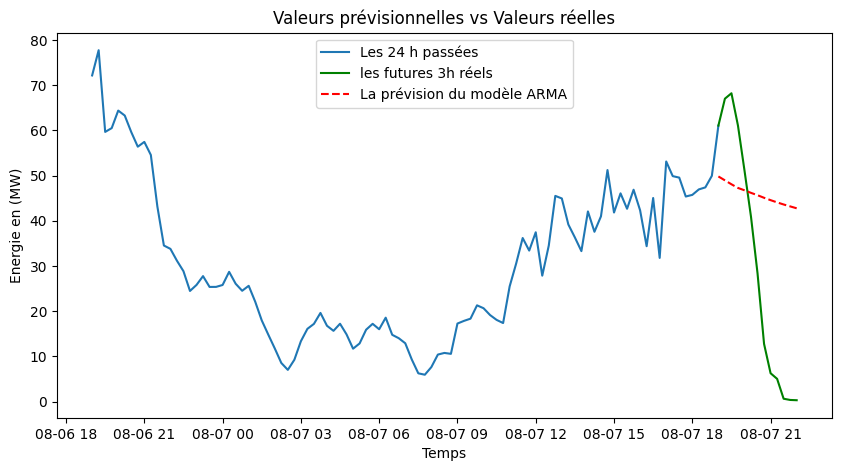

In [ ]:
prediciton_ARMA_w=evalute_model(model_ARMA_W,Wind_Power,train_W,test_W,24,24,None)

I-3_ARIMA


In [ ]:
'''
The "I" in ARIMA stands for "integrated," which means it includes differencing to make the time series stationary.
Differencing involves subtracting consecutive observations to remove trends or seasonality.
'''

In [ ]:
#build model ARIMA for solar power
model_ARIMA_S = sm.tsa.arima.ARIMA(train_S[:500], order=(96, 1, 1))
model_ARIMA_S=model_ARIMA_S.fit()
model_ARIMA_S.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Power (MW)   No. Observations:                  500
Model:                ARIMA(96, 1, 1)   Log Likelihood                -881.763
Date:                Thu, 10 Aug 2023   AIC                           1959.526
Time:                        12:47:45   BIC                           2372.361
Sample:                    01-01-2019   HQIC                          2121.535
                         - 01-06-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4642      0.347      1.338      0.181      -0.216       1.144
ar.L2          0.1191      0.032      3.762      0.000       0.057       0.181
ar.L3         -0.3303      0.058     -5.672      0.000      -0.444      -0.216
ar.L4          0.0477      0.105      0.455      0.649      -0.158       0.253
ar.L5          0.0595      0.056      1.059      0.289      -0.051       0.169
ar.L6         -0.0121      0.046     -0.263      0.793      -0.103       0.079
ar.L7         -0.0069      0.051     -0.136      0.892      -0.107       0.093
ar.L8          0.1003      0.054      1.873      0.061      -0.005       0.205
ar.L9         -0.1538      0.059     -2.622      0.009      -0.269      -0.039
ar.L10        -0.2596      0.077     -3.370      0.001      -0.411      -0.109
ar.L11         0.1866      0.123      1.519      0.129      -0.054       0.427
ar.L12         0.0256      0.065      0.391      0.696      -0.103       0.154
ar.L13        -0.0898      0.049     -1.819      0.069      -0.186       0.007
ar.L14         0.0007      0.067      0.011      0.991      -0.131       0.132
ar.L15        -0.1487      0.061     -2.430      0.015      -0.269      -0.029
ar.L16         0.0139      0.084      0.167      0.868      -0.150       0.178
ar.L17         0.0842      0.091      0.920      0.357      -0.095       0.264
ar.L18        -0.1395      0.084     -1.663      0.096      -0.304       0.025
ar.L19        -0.1779      0.099     -1.800      0.072      -0.372       0.016
ar.L20         0.0344      0.130      0.264      0.792      -0.220       0.289
ar.L21         0.0141      0.083      0.171      0.864      -0.148       0.176
ar.L22        -0.0593      0.090     -0.659      0.510      -0.236       0.117
ar.L23        -0.0074      0.114     -0.065      0.948      -0.231       0.216
ar.L24        -0.0344      0.091     -0.379      0.705      -0.212       0.143
ar.L25        -0.1642      0.104     -1.585      0.113      -0.367       0.039
ar.L26        -0.0040      0.128     -0.031      0.975      -0.255       0.247
ar.L27         0.0432      0.110      0.392      0.695      -0.173       0.260
ar.L28        -0.1326      0.126     -1.054      0.292      -0.379       0.114
ar.L29        -0.0801      0.141     -0.568      0.570      -0.356       0.196
ar.L30         0.0247      0.153      0.161      0.872      -0.275       0.324
ar.L31         0.0086      0.141      0.061      0.951      -0.268       0.285
ar.L32         0.0045      0.138      0.032      0.974      -0.267       0.276
ar.L33        -0.0233      0.136     -0.172      0.864      -0.289       0.242
ar.L34        -0.0710      0.164     -0.432      0.666      -0.393       0.251
ar.L35        -0.0451      0.145     -0.310      0.756      -0.330       0.240
ar.L36         0.0086      0.153      0.056      0.955      -0.290       0.308
ar.L37        -0.0325      0.150     -0.217      0.828      -0.327       0.262
ar.L38        -0.0610      0.166     -0.369      0.712      -0.385       0.263
ar

In [ ]:
#build model ARIMA for wind power
model_ARIMA_W = sm.tsa.arima.ARIMA(train_W, order=(36, 1, 3))
model_ARIMA_W=model_ARIMA_W.fit()
model_ARIMA_W.summary()

In [ ]:
prediciton_ARIMA_s=evalute_model(model_ARIMA_S,Solar_Power,train_S,test_S,24,24,'orange')

mae= 25.847333345327815
mse= 892.1751347562949
rmse= 29.869300874916622
mape= 27.71435441440142


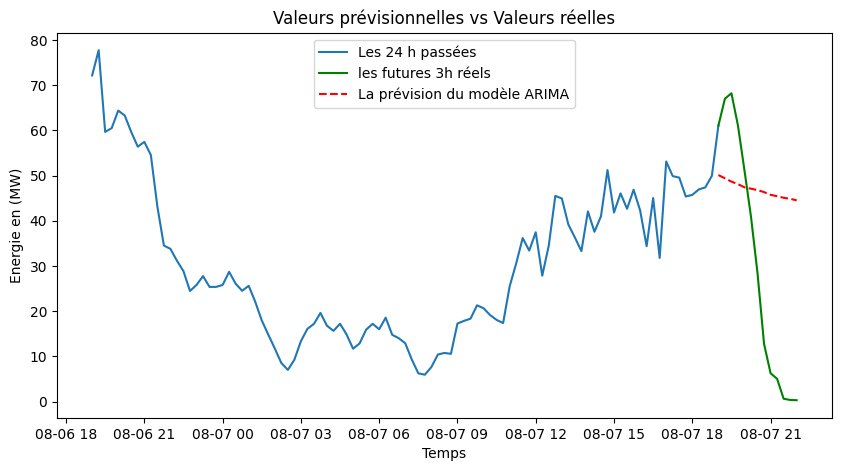

In [ ]:
prediciton_ARIMA_w=evalute_model(model_ARIMA_W,Wind_Power,train_W,test_W,96,12,None)

I-4_SARIMA


In [ ]:
sarima_model = pm.auto_arima(train_S,
                             seasonal=True,
                             m=96,  # Seasonal period is 96 (15-minute intervals in  an 24 hour)
                             stepwise=True,
                             suppress_warnings=True,
                             error_action='ignore')

print(sarima_model.summary())

In [ ]:
#build model SARIMA for solar power
model_SARIMA_S = sm.tsa.statespace.SARIMAX(train_S, order=(1, 1, 2),seasonal_order=(1, 1, 1, 96))
model_SARIMA_S=model_SARIMA_S.fit()
model_SARIMA_S.summary()

KeyboardInterrupt: ignored

In [ ]:
#build model SARIMA for wind power
model_SARIMA_W = sm.tsa.statespace.SARIMAX(train_S, order=(96, 1, 2),seasonal_order=(1, 1, 1, 96))
model_SARIMA_W=model_SARIMA_W.fit()
model_SARIMA_W.summary()

In [ ]:
prediciton_SARIMA_s=evalute_model(model_SARIMA_S,Solar_Power,train_S,test_S,96)

In [ ]:
prediciton_SARIMA_w=evalute_model(model_SARIMA_W,Solar_Power,train_W,test_W,96)

**Approche multivariée**

I-5_VARIMA

In [ ]:
#split data to feautres and label
def split_features_label(data,label=''):
  label=data[[label]].copy()
  features=data.drop(label,axis=1)
  return features,label

In [ ]:
features_S,label_S=split_features_label(solar_data,label='Power (MW)')
features_W,label_W=split_features_label(wind_data,label='Power (MW)')

In [ ]:
#split to train and test
#Split the data into train and test for solar data
train_S_f=features_S[:int(len(solar_data)*0.8)]
train_S_l=label_S[:int(len(solar_data)*0.8)]
test_S_f=features_S[int(len(solar_data)*0.8):]
test_S_l=label_S[int(len(solar_data)*0.8):]
#Split the data into train and test for wind data
train_W_f=features_W[:int(len(wind_data)*0.8)]
train_W_l=label_W[:int(len(wind_data)*0.8)]
test_W_f=features_W[int(len(wind_data)*0.8):]
test_W_l=label_W[int(len(wind_data)*0.8):]

In [ ]:
model_VARIMA_S = sm.tsa.VARIMA(train_S_l, exog=train_S_f, order= (p, d, q)).fit()

In [ ]:
model_VARIMA_W = sm.tsa.VARIMA(train_W_l, exog=train_W_f, order= (p, d, q)).fit()

In [ ]:
#out of project
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels')
pred.index=data.index[start:end+1]
print(pred)